# Segmentation Notebook for Tool Segmentation


### 1. Import Libraries

In [9]:
import segmentation_models_pytorch as smp
import torch
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

import src.data_utils as data_utils
import src.plot_utils as plot_utils
from src.ToolSegmentationDataset import Toolhead_Dataset
from src.Trainer import Trainer
from src.loss_functions import Dice_Segmentation_Loss

In [10]:
%pip install intel_extension_for_pytorch
import intel_extension_for_pytorch as ipex

###  2. Collect Data and create dataset (train and validation dataset)

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [12]:
# collect data from path
train_path = "./data/train"
valid_path = "./data/validation"

# scrap the full path string
train_img_path, train_annot_path = data_utils.collectDatasetImages(train_path)
valid_img_path, valid_annot_path = data_utils.collectDatasetImages(valid_path)

Optional: Augment dataset using torchvision transforms v2 for segmentation

In [13]:
img_resolution = [512, 512]

train_augmentations = transforms.Compose([
    transforms.Resize(img_resolution, antialias=False),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

valid_augmentations = transforms.Compose([
    transforms.Resize(img_resolution, antialias=False),
])

In [14]:
train_dataset = Toolhead_Dataset(train_img_path, train_annot_path, train_augmentations)
valid_dataset = Toolhead_Dataset(valid_img_path, valid_annot_path, valid_augmentations)

b_size = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=b_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=b_size, shuffle=False)

### 3. Model and Training:
- Initialize necessary model and parameters
- Initialize the Trainer and train model

In [15]:
unet = smp.Unet(
    encoder_name='resnet34', 
    encoder_depth=4, 
    encoder_weights='imagenet', 
    decoder_use_batchnorm=True, 
    decoder_channels=(128, 64, 32, 16), 
    decoder_attention_type=None, 
    in_channels=3, 
    classes=1, 
    activation=None, 
    aux_params=None
)

In [16]:
lr = 5e-3
optimizer = torch.optim.Adam(unet.parameters(), lr)
dice_loss = Dice_Segmentation_Loss()
label_counts = 2

unet, optimizer = ipex.optimize(model, optimizer=optimizer)

segmentation_trainer = Trainer(
    model=unet, 
    optimizer=optimizer, 
    criterion=dice_loss,
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    label_counts=label_counts,
    epochs=50, 
    print_intermediate_vals=True, 
    gradient_accumulation=1,
    save_model_on_every_epoch=False
    )

### Alternative: Load prior trained model

In [17]:
saved_model_path = "./models/epoch_49.pth"
segmentation_trainer.load_model(saved_model_path)

In [18]:
# segmentation_trainer.train_model()

### 4. Save Values and evaluate - Plots

In [19]:
train_loss = segmentation_trainer.train_loss
val_loss = segmentation_trainer.val_loss
loss_iters = segmentation_trainer.loss_iters
valid_mIoU = segmentation_trainer.valid_mIoU
valid_mAcc = segmentation_trainer.valid_mAcc
conf_mat = segmentation_trainer.conf_mat

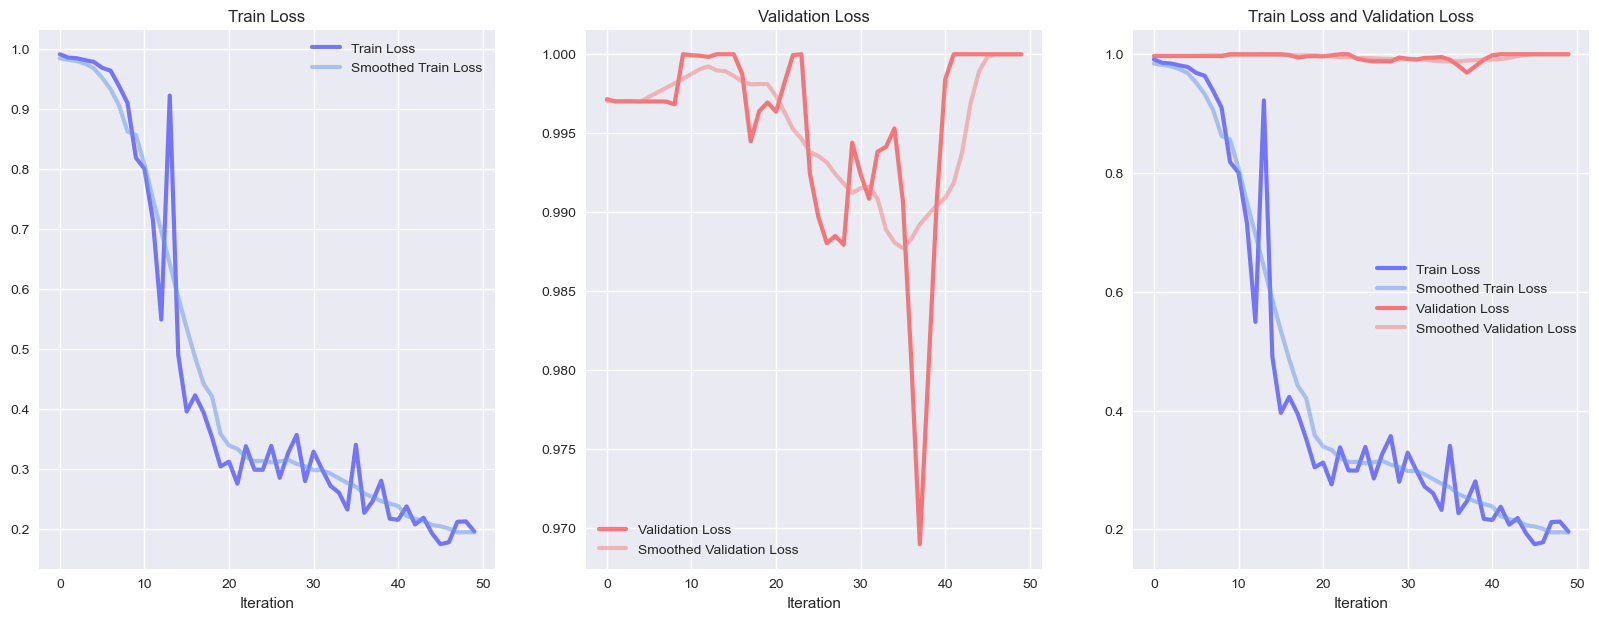

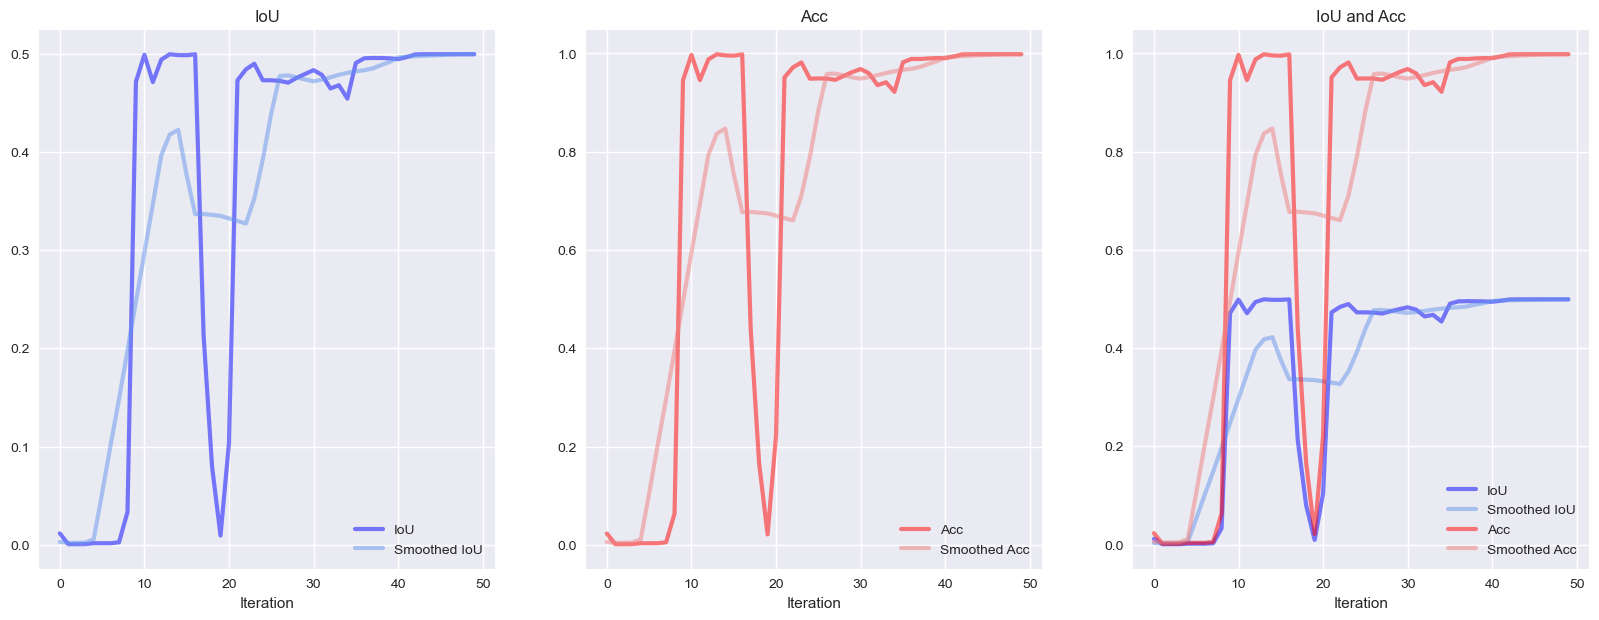

In [20]:
_, loss_ax = plot_utils.plot_results(train_loss, val_loss, ["Train Loss", "Validation Loss"])
_, measure_ax = plot_utils.plot_results(valid_mIoU, valid_mAcc, ["IoU", "Acc"])
plt.show()

### 5. Save and/or Plot Segmentation masks

#### 5.1 Train img Plot

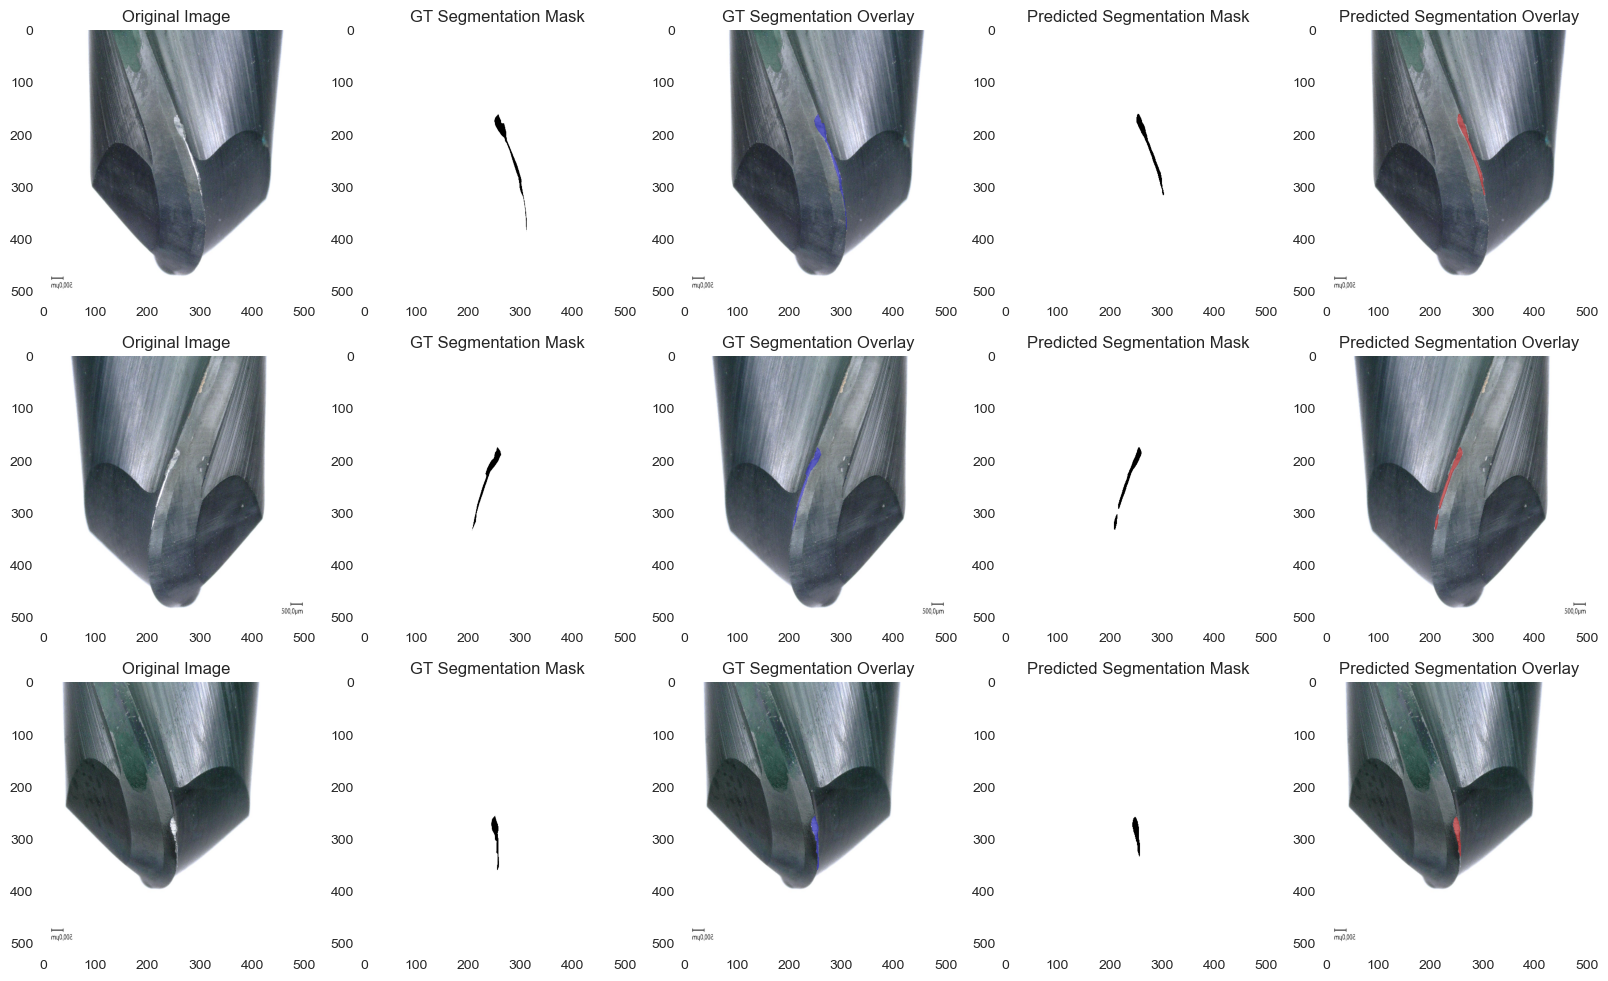

In [21]:
# plots
_, ax = plt.subplots(len(train_dataset), 5, figsize=(20,12))

for i, (img, gt_segmentation) in enumerate(train_dataset):
    
    img = img.unsqueeze(0).to(device)

    preds = segmentation_trainer.model(img)
    # prediction to one hot encoding
    one_hot = torch.sigmoid(preds)
    one_hot[one_hot >= 0.5] = 1
    one_hot[one_hot < 0.5] = 0

    one_hot = one_hot.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)
    gt_segmentation = gt_segmentation.numpy().transpose(1, 2, 0)
    
    vb_img = plot_utils.segment_mask_as_overlay(img, one_hot, color="red")
    vb_gt = plot_utils.segment_mask_as_overlay(img, gt_segmentation, color="blue")

    ax[i][0].grid(False)
    ax[i][0].set_title("Original Image")
    ax[i][1].grid(False)
    ax[i][1].set_title("GT Segmentation Mask")
    ax[i][2].grid(False)
    ax[i][2].set_title("GT Segmentation Overlay")
    ax[i][3].grid(False)
    ax[i][3].set_title("Predicted Segmentation Mask")
    ax[i][4].grid(False)
    ax[i][4].set_title("Predicted Segmentation Overlay")
    ax[i][0].imshow(img)
    ax[i][1].imshow(gt_segmentation)
    ax[i][2].imshow(vb_gt)
    ax[i][3].imshow(one_hot)
    ax[i][4].imshow(vb_img)


#### 5.2 Test img Plot. Optional: Save

A total of 2 images found in given path.


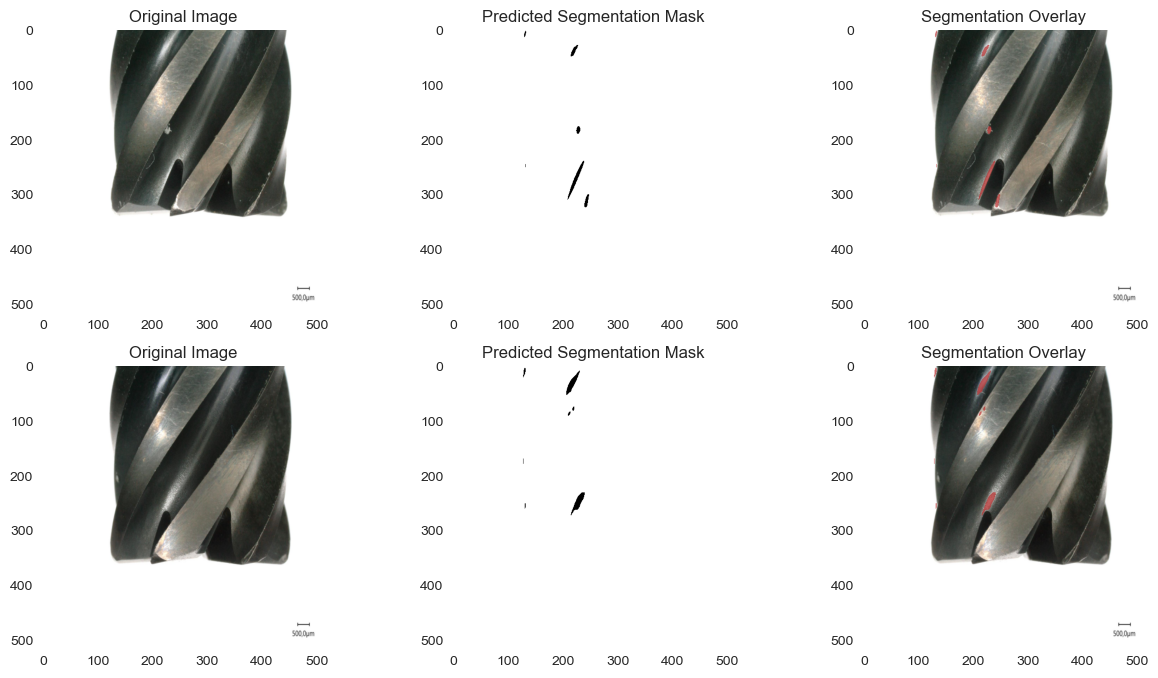

In [22]:
test_path = "./data/test/"
test_img_paths = data_utils.collectImagePaths(test_path)

save = True
save_folder = "./data/segmented_imgs/"
os.makedirs(os.path.dirname(save_folder), exist_ok=True)

# plots
_, ax = plt.subplots(len(test_img_paths), 3, figsize=(15,8))

for i, path in enumerate(test_img_paths):
    # load image
    img = Image.open(path)
    # convert PIL to Tensor
    img = F.pil_to_tensor(img)

    # process image:
    img = F.resize(img, img_resolution, antialias=True)
    img = img / img.max()
    img = img.float().to(device)

    if len(img.shape) == 3:
        img = img.unsqueeze(0)

    preds = segmentation_trainer.model(img)
    # prediction to one hot encoding
    one_hot = torch.sigmoid(preds)
    one_hot[one_hot >= 0.5] = 1
    one_hot[one_hot < 0.5] = 0

    one_hot = one_hot.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)
    
    vb_img = plot_utils.segment_mask_as_overlay(img, one_hot, color="red")

    ax[i][0].grid(False)
    ax[i][0].set_title("Original Image")
    ax[i][1].grid(False)
    ax[i][1].set_title("Predicted Segmentation Mask")
    ax[i][2].grid(False)
    ax[i][2].set_title("Segmentation Overlay")
    ax[i][0].imshow(img)
    ax[i][1].imshow(one_hot)
    ax[i][2].imshow(vb_img)

    if save == True:
        file_name = os.path.basename(path)
        name_without_extension = os.path.splitext(file_name)[0]
        # for cv2 it wants values between 0 and 255 and BGR Channels instead of RGB
        cv2.imwrite(save_folder + name_without_extension + "_segmented.jpg", vb_img[:, :, ::-1] * 255)
